In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
   

In [3]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from datasets import load_dataset

# Load dataset
dataset = load_dataset('ag_news')

# Tokenize data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Select 5000 samples for training and 5000 for testing
train_dataset = dataset["train"].shuffle(seed=42).select(range(5000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(5000))


# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

def preprocess_data(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)


# Prepare data for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])



train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model.train()

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [4]:
#SVD
#Sparse matrix
#U,V
#Replace Everything

import torch
import torch.nn as nn

def svd(m,rank):
  u,s,v = torch.linalg.svd(m)
  diag_shape = min(s.shape[0], rank)
  L = u[:, :diag_shape] @ torch.sqrt(torch.diag(s)[:diag_shape, :diag_shape])
  R = torch.sqrt(torch.diag(s)[:diag_shape, :diag_shape]) @ v[:diag_shape, :]


  return L,R

class LinearLoSparse(nn.Module):
  def __init__(self,in_feature,out_feature,reduced_rank, has_bias = True, has_sparse = True):
    super().__init__()
    self.in_feature = in_feature
    self.out_feature = out_feature
    self.reduced_rank = reduced_rank
    self.has_bias = has_bias
    self.has_sparse = has_sparse


    self.right = nn.Linear(in_feature, reduced_rank, bias=False)
    self.left = nn.Linear(reduced_rank, out_feature, bias=False)

    if self.has_sparse:
      self.sparse = nn.Linear(in_feature, out_feature, bias=False)

    if self.has_bias:
      self.bias = nn.Parameter(torch.zeros(out_feature, requires_grad=True))

  def forward(self, x):
    "W = LR + S"
    """Y = XW.T+B = X(LR+S).T+B = X(LR).T+XS.T+B"""
    LRX = self.left(self.right(x))
    SX_ = self.sparse(x)

    Y = LRX + SX_ + self.bias if self.has_bias else LRX + SX_
    return Y

  def initialize_weights(self,left,right,sparse=None,bias=None):
    self.left.weight = nn.Parameter(left, requires_grad=True)
    self.right.weight = nn.Parameter(right, requires_grad=True)
    if self.has_sparse:
      self.sparse.weight = nn.Parameter(sparse, requires_grad=True)
    if self.has_bias:
      self.bias = nn.Parameter(bias, requires_grad=True)


def ReplaceWeight(model,attr_str,matrix,rank):
  L,R = svd(matrix,rank)
  S = matrix - torch.mm(L,R)

  # Check if the original module has a bias term
  has_bias = hasattr(matrix, 'bias')
  linear_loras = LinearLoSparse(matrix.shape[0],matrix.shape[1],rank,has_bias=has_bias,has_sparse=True)
  if has_bias:

    linear_loras.initialize_weights(L,R,S,matrix.bias)
  else:
    linear_loras.initialize_weights(L,R,S)

  parent_module = model
  attr_parts = attr_str.split('.')
  for part in attr_parts[:-1]:
      parent_module = getattr(parent_module, part)
  "encoder.layer[0].attention.query"
  setattr(parent_module,attr_parts[-1],linear_loras )
  #setattr(model,attr_str,linear_loras)
  print(f"Replaced layer:{attr_parts[-1]}")

def replace_weights(model,rank,allow_name=None,has_sparse=True):

  if allow_name is None:
      allow_name = ['query', 'key', 'value', 'dense', 'attention']
  #if block_name is None:
  #    block_name = ['pooler', 'classifier', 'LayerNorm', 'embeddings']
  modules_to_replace = []
  for module_name, module in model.named_modules():

    if not isinstance(module, nn.Linear):
        continue

    if not any(target_key in module_name for target_key in allow_name):
        continue

    modules_to_replace.append((module_name,module))

  for module_name,module in modules_to_replace:


    ReplaceWeight(model,module_name,module.weight.data,rank)
    print(module_name,'replaced')

In [8]:
replace_weights(model,100)

Replaced layer:query
bert.encoder.layer.0.attention.self.query replaced
Replaced layer:key
bert.encoder.layer.0.attention.self.key replaced
Replaced layer:value
bert.encoder.layer.0.attention.self.value replaced
Replaced layer:dense
bert.encoder.layer.0.attention.output.dense replaced
Replaced layer:dense
bert.encoder.layer.0.intermediate.dense replaced
Replaced layer:dense
bert.encoder.layer.0.output.dense replaced
Replaced layer:query
bert.encoder.layer.1.attention.self.query replaced
Replaced layer:key
bert.encoder.layer.1.attention.self.key replaced
Replaced layer:value
bert.encoder.layer.1.attention.self.value replaced
Replaced layer:dense
bert.encoder.layer.1.attention.output.dense replaced
Replaced layer:dense
bert.encoder.layer.1.intermediate.dense replaced
Replaced layer:dense
bert.encoder.layer.1.output.dense replaced
Replaced layer:query
bert.encoder.layer.2.attention.self.query replaced
Replaced layer:key
bert.encoder.layer.2.attention.self.key replaced
Replaced layer:value

In [9]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): LinearLoSparse(
                (right): Linear(in_features=768, out_features=100, bias=False)
                (left): Linear(in_features=100, out_features=768, bias=False)
                (sparse): Linear(in_features=768, out_features=768, bias=False)
              )
              (key): LinearLoSparse(
                (right): Linear(in_features=768, out_features=100, bias=False)
                (left): Linear(in_features=100, out_

In [14]:
class Pruner(object):
  def __init__(self, model,
                 mask_param_name=None,
                 non_mask_name=None,
                 use_no_mask=False,
                 threshold = 0.15,
                 warm_up_steps = 100,
                 final_warm_up_steps = 200,
                 max_training_steps = 500,
                 beta1 = 0.5
                 ):

        if non_mask_name is None:
            non_mask_name = ["embedding", "norm"]
        if mask_param_name is None:
            mask_param_name = ['sparse']
        self.model = model


        self.ipt = {}
        self.exp_avg_ipt = {}
        self.exp_avg_unc = {}
        self.mask_param_name = mask_param_name
        self.non_mask_name = non_mask_name


        self.threshold = threshold

        self.beta1 = beta1

        self.final_threshold = threshold
        self.warm_up_steps = warm_up_steps
        self.final_warm_up_steps = final_warm_up_steps
        self.max_training_steps = max_training_steps

  def thresholdingschedule(self,step):
    if step < self.warm_up_steps:
      applymask = 0

    elif self.warm_up_steps <= step and step < (self.max_training_steps - self.final_warm_up_steps):
      cubicstep_nom = step - self.warm_up_steps - self.final_warm_up_steps
      cubicstep_denom = self.max_training_steps - self.warm_up_steps - self.final_warm_up_steps

      self.threshold = self.threshold + (1-self.threshold)*((1+(cubicstep_nom/cubicstep_denom))**3)
      self.threshold = 1 - self.threshold

      applymask = 1

    else:
      applymask = 1
      self.threshold = self.final_threshold

    return applymask

  def correctparam(self,n):
    return any(nd in n for nd in self.mask_param_name)

  def prune(self, is_dict_mat, name):
    num_row, num_col = is_dict_mat.shape
    return torch.mean(is_dict_mat, dim=1, keepdim=True).repeat((1, num_col))

  def iterative_prune(self,model):
    ##using the PLATON method
    for n,p in model.named_parameters():
      if self.correctparam(n):
        if n not in self.exp_avg_ipt:
          self.ipt[n] = torch.zeros_like(p)
          self.exp_avg_ipt[n] = torch.zeros_like(p)
        self.exp_avg_ipt[n] = self.beta1 * self.exp_avg_ipt[n] + (1 - self.beta1) * self.ipt[n]

        self.ipt[n] = (p * p.grad).abs().detach()

  def mask_w_threshold(self,model,threshold):
    is_dict = {}
    for n, p in model.named_parameters():
      if self.correctparam(n):
        if len(self.exp_avg_ipt[n].shape) == 2:
            is_dict[n] = self.prune(self.exp_avg_ipt[n], n)
    # Calculate the mask threshold
    all_is = torch.cat([is_dict[n].view(-1) for n in is_dict])
    mask_threshold = torch.kthvalue(all_is, int(all_is.shape[0] * (1 - threshold)))[0].item()
    # Mask weights whose importance lower than threshold
    for n, p in model.named_parameters():
        if self.correctparam(n):
            p.data.masked_fill_(is_dict[n] < mask_threshold, 0.0)
    return mask_threshold

  def doitall(self,model,global_step):
    self.iterative_prune(model)
    apply_mask = self.thresholdingschedule(global_step)
    if apply_mask == 1:

      mask_threshold = self.mask_w_threshold(model,self.threshold)
      print(f'Mask Thresholded: {self.threshold:.3%}')
    else:
      print('No Masked')


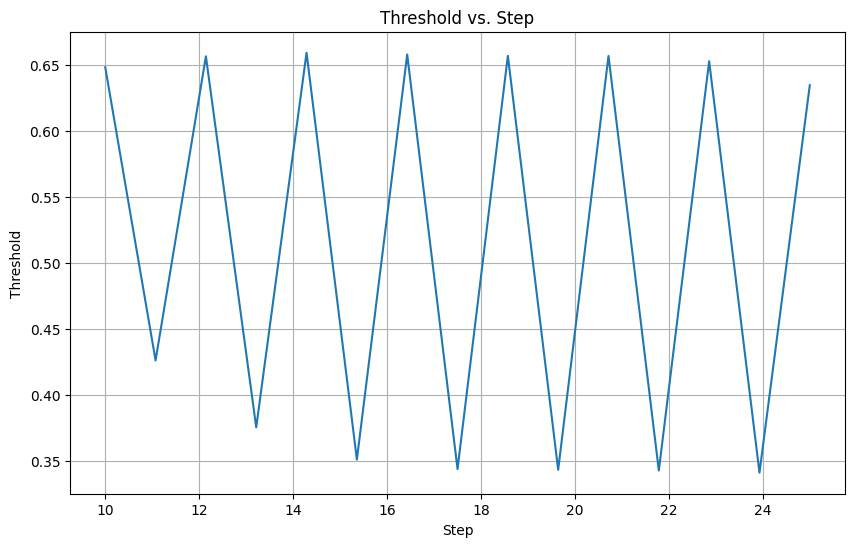

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
warm_up_steps = 10
final_warm_up_steps = 25
max_training_steps = 50
threshold = 0.5  # Starting value for threshold

# Create a range of steps
steps = np.linspace(warm_up_steps , max_training_steps - final_warm_up_steps, final_warm_up_steps - warm_up_steps)

# Calculate threshold for each step
thresholds = []
for step in steps:
    cubicstep_nom = step - warm_up_steps - final_warm_up_steps
    cubicstep_denom = max_training_steps - warm_up_steps - final_warm_up_steps

    threshold = threshold + (1 - threshold) * (1+(cubicstep_nom / cubicstep_denom) )** 3
    threshold = 1 - threshold
    thresholds.append(threshold)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(steps, thresholds)
plt.title('Threshold vs. Step')
plt.xlabel('Step')
plt.ylabel('Threshold')
plt.grid(True)
plt.show()

In [15]:
pruner = Pruner(model,warm_up_steps = 10,
                 final_warm_up_steps = 25,
                 max_training_steps = 50,
                threshold = 0.5)

In [35]:
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for step,batch in enumerate(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        ##################################
        if step >= pruner.warm_up_steps :#
          pruner.doitall(model,step)     #
        ##################################

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        print(step)
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")

    # Evaluate on the test set
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_eval_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    avg_eval_loss = total_eval_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions
    print(f"Validation Loss: {avg_eval_loss}, Accuracy: {accuracy}")

    model.train()

0
1
2
3
4
5
6
7
8
9
Mask Thresholded: 64.815%
10
Mask Thresholded: 42.785%
11
Mask Thresholded: 65.895%
12
Mask Thresholded: 37.572%
13
Mask Thresholded: 66.424%
14
Mask Thresholded: 34.820%
15
Mask Thresholded: 66.416%
16
Mask Thresholded: 33.852%
17
Mask Thresholded: 66.304%
18
Mask Thresholded: 33.706%
19
Mask Thresholded: 66.294%
20
Mask Thresholded: 33.696%
21
Mask Thresholded: 66.147%
22
Mask Thresholded: 33.582%
23
Mask Thresholded: 65.159%
24
Mask Thresholded: 50.000%
25
Mask Thresholded: 50.000%
26
Mask Thresholded: 50.000%
27
Mask Thresholded: 50.000%
28
Mask Thresholded: 50.000%
29
Mask Thresholded: 50.000%
30
Mask Thresholded: 50.000%
31
Mask Thresholded: 50.000%
32
Mask Thresholded: 50.000%
33
Mask Thresholded: 50.000%
34
Mask Thresholded: 50.000%
35
Mask Thresholded: 50.000%
36
Mask Thresholded: 50.000%
37
Mask Thresholded: 50.000%
38
Mask Thresholded: 50.000%
39
Mask Thresholded: 50.000%
40
Mask Thresholded: 50.000%
41
Mask Thresholded: 50.000%
42
Mask Thresholded: 50.00

In [39]:
all_values = 0
zeros = 0
for p in model.bert.encoder.layer[9].output.dense.sparse.weight.data[:4,:].view(-1):
  if p == 0:
    zeros += 1
  all_values += 1
print(zeros/all_values)

0.5
